## Airsoft Target Detection

In [170]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from skimage import io



def show_image(img, cmap=None, name=None, size=None):
    if size is not None:
        plt.figure(figsize=size)
    else:
        plt.figure(figsize=(3,3))
    if cmap is not None:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.axis('off')
    if name is not None:
        plt.title(name)
    plt.show()


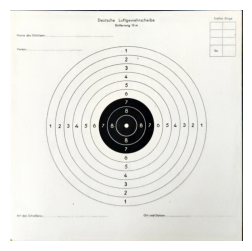

(1942, 1952, 3)

In [171]:
image = io.imread('resources/aligned/clean_small_1.jpg')
#image = cv2.resize(image, (0, 0), fx=0.35, fy=0.35)
show_image(image)
image.shape

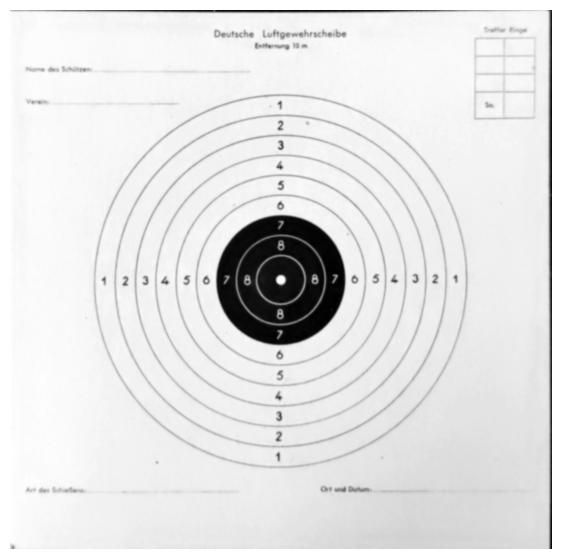

In [172]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel = np.ones((5, 5), np.uint8)  
#gray_image = cv2.erode(gray_image, kernel)
gray_image = cv2.GaussianBlur(gray_image, (15,15), 0)
# gray_image = cv2.bitwise_not(gray_image) 
# gray_image = cv2.resize(gray_image, (0, 0), fx=0.35, fy=0.35)
show_image(gray_image, cmap='gray', size=(7,7))

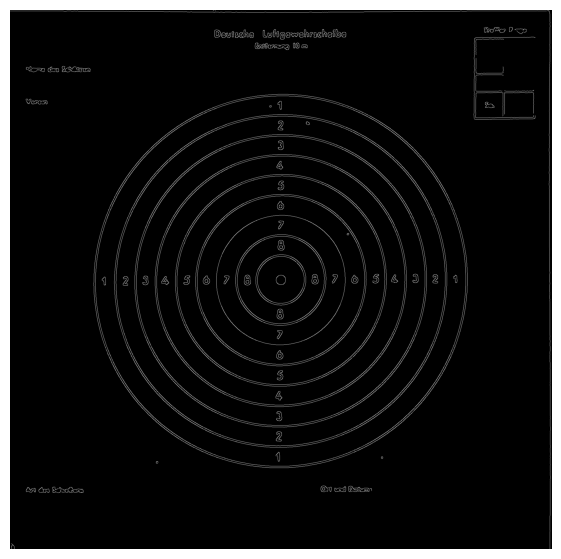

In [173]:
canny = cv2.Canny(image=gray_image, threshold1=30, threshold2=70)
# canny = io.imread('resources/aligned/test.png')
# canny = cv2.cvtColor(canny, cv2.COLOR_BGR2GRAY)
show_image(canny, cmap='gray', size=(7,7))

In [174]:
# circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, dp=1, minDist=10, param1=150, param2=30, minRadius=0, maxRadius=0)
# circles = np.round(circles[0, :]).astype("int")

In [175]:
# output_1 = np.copy(image)
# output_2 = np.zeros_like(image)

# for (x, y, r) in circles:
#     output_1 = cv2.circle(output_1, (x, y), r, (255, 0, 0), 1)
#     output_2 = cv2.circle(output_2, (x, y), r, (255, 0, 0), 1)
# show_image(output_1, size=(7,7))
# show_image(output_2, size=(7,7))

In [176]:
# output_1 = np.copy(image)
# output_2 = np.zeros_like(image)

# median_xy = np.median(circles[:, :2], axis=0).astype("int")
# median_x = 398 # median_xy[0]
# median_y = 402 # median_xy[1]

# filtered_circles = circles[(np.abs(circles[:, 0] - median_x) <= 10) & (np.abs(circles[:, 1] - median_y) <= 10)]

# for (x, y, r) in filtered_circles:
#     output_1 = cv2.circle(output_1, (x, y), r, (255, 0, 0), 1)
#     output_2 = cv2.circle(output_2, (x, y), r, (255, 0, 0), 1)
# output_1 = cv2.circle(output_1, (median_x, median_y), 1, (0, 0, 255), 4)
# output_2 = cv2.circle(output_2, (median_x, median_y), 1, (0, 0, 255), 4)
# show_image(output_1, size=(7,7))
# show_image(output_2, size=(7,7))
# median_x, median_y

C:\Users\nicla\AppData\Local\Temp\ipykernel_15092\2827024210.py:14: RuntimeWarning: invalid value encountered in divide
  acc = acc / np.arange(width)


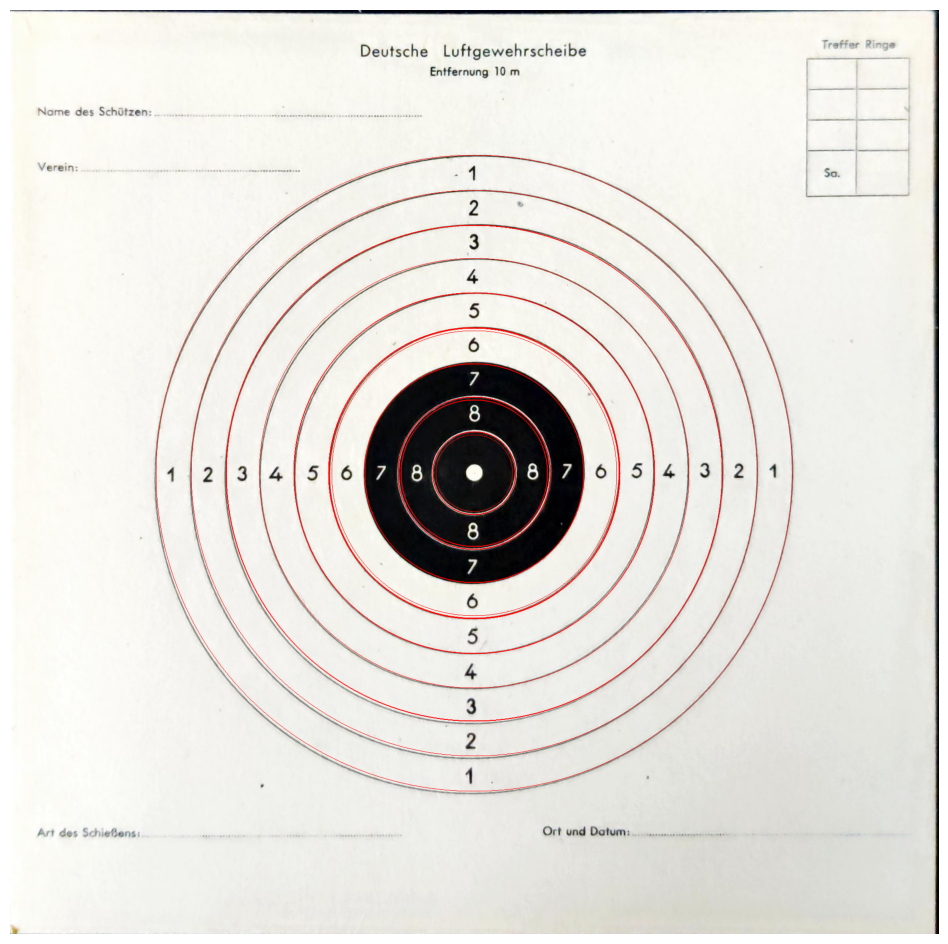

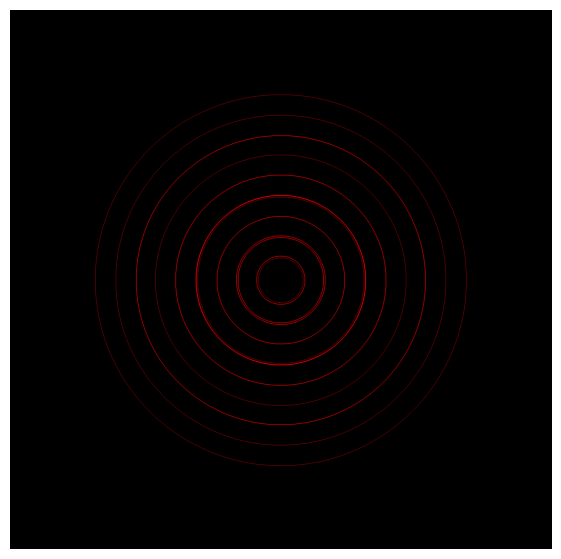

In [178]:
def houghCirclesAroundFix(image, fix):
    width, height = image.shape
    acc = np.zeros(width)
    x_f, y_f = fix
    for x in range(width):
        for y in range(height):
            if image[x, y] > 0:
                radius = np.floor(np.sqrt((x_f - x)**2 + (y_f - y)**2)).astype("int")
                # # Todo: fix dirty hack
                # if radius >= width / 2.2: continue
                acc[radius] = acc[radius] + 1
    # TODO: use radius value to normalize max_val => bigger circle more points on it
    # divide each value of acc by its index to normalize in a single line
    acc = acc / np.arange(width)
    acc = acc * 100
    max_val = np.max(acc)
    acc[acc < 150] = 0
    indices = np.nonzero(acc)
    indices = np.array(indices).astype("int").flatten()
    return indices
    
x, y, _ = image.shape
x = x // 2 + 3
y = y // 2 - 3
output_1 = np.copy(image)
output_2 = np.zeros_like(image)
circles = houghCirclesAroundFix(canny, (x, y))
for r in circles:
    output_1 = cv2.circle(output_1, (x, y), r, (255, 0, 0), 1)
    output_2 = cv2.circle(output_2, (x, y), r, (255, 0, 0), 1)
show_image(output_1, size=(12,12))
show_image(output_2, size=(7,7))